# 1) Data cleaning

### Read files into dataframe

In [199]:
import pandas as pd 
import os
import glob

path = os.getcwd()
folder_name = "data" 
xlsx_files = glob.glob(os.path.join(path+"/"+folder_name, "*.xlsx"))

li = []
col_names = ['score', 'username', 'review_fr', 'company', 'product', 'type', 'date_publication', 'date_exp', 'review_en', 'review_corrected_fr', 'review_corrected_en']
for f in xlsx_files:
    df = pd.read_excel(f, index_col=None, header=0, names=col_names)
    li.append(df)

dataframe = pd.concat(li, axis=0, ignore_index=True)
dataframe.head()


,score,username,review_fr,company,product,type,date_publication,date_exp,review_en,review_corrected_fr,review_corrected_en
0,NaN,estelle-51227,j'ai quitté mon ancien contrat d'assurance chez Générali l'année derniere pour rejoindre le groupe Néoliane et je peux dire maitnenant après un an que la seule chose qui change... c'est le prix ! Je suis assuré de la même façon et pourtant je paye 30% de moins par mois ce uqi sur un an me fait économiser une fortune. Donc resté assuré aujourd'hui chez le même prouve bien que la seule chose que nous gagnons ce sont des hausses de cotisations. Marre de payer.,Néoliane Santé,sante,test,12/01/2017,01/01/2017,I left my former insurance contract at General for the year to join the Néoliane group and I can say mastering after a year that the only thing that changes ... It's the price! I am assured in the same way and yet I pay 30% less per month this UQI over a year saves me a fortune. So remained assured today in the same proves that the only thing we earn are contributions of contributions. Tired of paying.,NaN,NaN
1,NaN,leadum-51107,"j'ai souscrit à cette mutuelle l'année derniere et je suis restée un an, j'ai trouvé la formule très avantageuse car le tarif était très intéressant pour mes lentilles et lunettes. J'ai pris la décision d'en changer car j'ai besoin d'orthodoncie et je ne l'avais pas par contre dans ma formule précédente.",Néoliane Santé,sante,test,09/01/2017,01/01/2017,"I subscribed to this mutual a year last year and I stayed for a year, I found the formula very advantageous because the price was very interesting for my lenses and glasses. I made the decision to change it because I need orthodonia and I did not have it in my previous formula.",NaN,NaN
2,NaN,enora-49520,"Impossible d'avoir le bon service , ils raccroche au nez quand il ne savent pas quoi répondre ils nous balade de service en service les papiers il faut les envoyer plusieurs fois et c'est jamais la même adresse ils sont mal poli je vous déconseillé cette mutuelle sincèrement",Néoliane Santé,sante,test,24/11/2016,01/11/2016,"Impossible to have the right service, they hang up on the nose when they do not know what to answer they walk from service to service the papers we must send them several times and it is never the same address they are badly polished I advise you this mutual",NaN,NaN
3,NaN,bea-139295,"Génération est une mutuelle très chère pour un retraité : + de 150 € par mois ! et malgré cela, impossible d'avoir un conseiller en ligne ! à part une voix électronique qui répète toujours la même chose. comment se fait il que pour une question simple posée sur votre site, on n'ait toujours pas de réponse 5 jours après ???\npour une fois que j'essaie de vous contacter par téléphone, je suis très déçue.\nje n'ose imaginer le jour où on doit vous contacter pour une hospitalisation urgente.... !",Génération,sante,test,09/11/2021,01/11/2021,"Generation is a very expensive mutual for a retiree: more than 150 € per month! And despite this, it is impossible to have an online advisor! Apart from an electronic voice that always repeats the same thing. How is it that for a simple question asked on your site, we still have no answer 5 days after ???\nFor once I try to contact you by phone, I am very disappointed.\nI dare not imagine the day when you have to contact you for urgent hospitalization ....!",NaN,NaN
4,NaN,anna-139192,"je viens d apprendre que je suis radié... j appel, une conseillere ne peux me donner de reponse me renvoie a un numero ... le sien, que je viens de faire et auquel j ai passé plus de 5 minutes a attendre plus les 9 minutes quand elle a essaye de me mettre en relation avec une autre personne ( 21.54minutes en tout). L autre numero que la conseillere m a donné me recroche au bout de 4.26minutes c est moins long!.\nLors de mon adhesion j ai eu un probleme j etais deja chez eux en tant que salarié, j ai voulu garder mon contrat en tant que particulier : ils ne savent pas faire a priori puisqu il m ont

### Data cleaning

In [200]:
print(dataframe.isna().sum())
total_rows = dataframe.shape[0]
print(f"Total number of rows: {total_rows}")

score                  10331
username                   1
review_fr                  0
company                    0
product                    0
type                       0
date_publication           0
date_exp                   0
review_en                  2
review_corrected_fr    34000
review_corrected_en    34004
dtype: int64
Total number of rows: 34435


Handling missing values

In [201]:
df.dropna(subset=['score', 'review_en'], inplace=True)

#remove columns not needed
df.drop(columns=['username', 'review_fr', 'company', 'product', 'type', 'date_publication', 'date_exp', 'review_corrected_fr', 'review_corrected_en'], inplace=True)

Lowercasing

In [202]:
def lowercase(frame):
    frame['review_en'] = frame['review_en'].map(lambda r: r.lower())

lowercase(df)

Remove punctuation

In [203]:
def remove_punctuation(df):
    df['review_en'] = df['review_en'].str.replace('[^\w\s]','', regex=True)

remove_punctuation(df)

Spelling correction

In [204]:
# # pip install pyspellchecker
# from spellchecker import SpellChecker
# def spelling_correction(df):
#     spell = SpellChecker()
#     df['review_en'] = [[spell.correction(word) for word in row] for row in df['review_en'].str.split(" ").to_list()]
#     df['review_en'] = df['review_en'].apply(lambda x: " ".join(x))

# spelling_correction(df)

Stopwords removal

In [205]:
from nltk.corpus import stopwords

def remove_stopwords(df):
    stop = stopwords.words('english')
    df['review_without_stopwords'] = df['review_en'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

remove_stopwords(df)

Tokenization

In [206]:
import nltk

def tokenize(df, column_to_tokenize):
    # Adds a column 'tokenized_rev' that contains for each entry a python list of words contained in the review
    df['tokenized_rev'] = df.apply(lambda row: nltk.word_tokenize(row[column_to_tokenize]), axis=1)

tokenize(df, 'review_without_stopwords')

Lemmatization

In [207]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('punkt')  # If working with tokenized data
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import wordnet

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default as noun

# Lemmatization function with POS tagging
def lemmatize_col(df, list_column_to_lemmatize):
    lmtzr = WordNetLemmatizer()
    # Tokenize and apply lemmatization with POS
    df['lemmatized'] = df[list_column_to_lemmatize].apply(lambda lst: [lmtzr.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tag(lst)]
    )

lemmatize_col(df, 'tokenized_rev')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/Alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Alberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [209]:
df.head()

,score,review_en,review_without_stopwords,tokenized_rev,lemmatized
0,4,new member and having been in contact with pope i am completely satisfied with the answers provided his listening and her patience aline louvet,new member contact pope completely satisfied answers provided listening patience aline louvet,"[new, member, contact, pope, completely, satisfied, answers, provided, listening, patience, aline, louvet]","[new, member, contact, pope, completely, satisfy, answer, provide, listen, patience, aline, louvet]"
1,1,latable telephone service impossibility of having an answer on career updating for more than 8 months and the only response to the phone refers to a transmission to the competent services without taking into account the request and without commitment on a response time\nrefusal to transmit or give the contact details of a manager no indication of the complaint service\nit is scandalous in 2021 that this type of operation can still exist,latable telephone service impossibility answer career updating 8 months response phone refers transmission competent services without taking account request without commitment response time refusal transmit give contact details manager indication complaint service scandalous 2021 type operation still exist,"[latable, telephone, service, impossibility, answer, career, updating, 8, months, response, phone, refers, transmission, competent, services, without, taking, account, request, without, commitment, response, time, refusal, transmit, give, contact, details, manager, indication, complaint, service, scandalous, 2021, type, operation, still, exist]","[latable, telephone, service, impossibility, answer, career, update, 8, month, response, phone, refers, transmission, competent, service, without, take, account, request, without, commitment, response, time, refusal, transmit, give, contact, detail, manager, indication, complaint, service, scandalous, 2021, type, operation, still, exist]"
2,5,i am very satisfied with all the services offered by the gmf i have been a customer for many years and have never had to complain,satisfied services offered gmf customer many years never complain,"[satisfied, services, offered, gmf, customer, many, years, never, complain]","[satisfied, service, offer, gmf, customer, many, year, never, complain]"
3,4,i am satisfied the price suits me very well i knew april thanks to my work colleagues and their thanks very much have to be registered with you me it suits me very well,satisfied price suits well knew april thanks work colleagues thanks much registered suits well,"[satisfied, price, suits, well, knew, april, thanks, work, colleagues, thanks, much, registered, suits, well]","[satisfied, price, suit, well, know, april, thanks, work, colleague, thanks, much, register, suit, well]"
4,4,i nickel for the moment no sinister we will see in usel home and reactivity ok personal rather nice and listening price well place,nickel moment sinister see usel home reactivity ok personal rather nice listening price well place,"[nickel, moment, sinister, see, usel, home, reactivity, ok, personal, rather, nice, listening, price, well, place]","[nickel, moment, sinister, see, usel, home, reactivity, ok, personal, rather, nice, listen, price, well, place]"


# 2) Handling Imbalanced Data

score
1    311
5    227
4    197
2    142
3    123
Name: count, dtype: int64


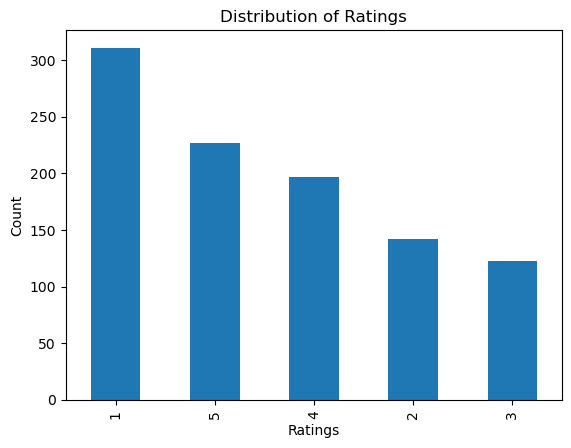

In [ ]:
import matplotlib.pyplot as plt

# Check the distribution of labels
label_counts = df['score'].value_counts()
print(label_counts)

# Plot the distribution of labels
label_counts.plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()